In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.dataloading import DataLoader
from src.preprocessing import Preprocesser
from src.vae_lstm import LSTMVAE

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
LATENT_DIM: int = 20

# Load Data

In [5]:
dataloader = DataLoader(path_to_data="../data/raw/P01")
df_list: list[pd.DataFrame] = dataloader.load_data()

2023-12-18 20:35:30,745 - src.dataloading - INFO - Found 10 .csv files in input path '../data/raw/P01' ...
2023-12-18 20:35:46,842 - src.dataloading - INFO - Parsed 10 .csv files into DataFrames ...


# Preprocess Data

In [6]:
preprocessor_train = Preprocesser(df_list=df_list, condition="MathxHard", rolling_window_size=250, fixed_size=10990)
tensor: np.array = preprocessor_train.preprocess_data()
FEATURE_NAMES = list(preprocessor_train.df_list_processed[0].columns)

print(tensor.shape)

2023-12-18 20:35:47,051 - src.preprocessing - INFO - Starting preprocessing pipeline (Condition: MathxHard, Window Size: 250, Fixed Size: 10990) ...
2023-12-18 20:35:47,184 - src.preprocessing - INFO - Stacking data to 3D tensor ...
2023-12-18 20:35:47,188 - src.preprocessing - INFO - Finished preprocessing pipeline (Duration: 0.14s) ...


(430, 250, 7)


# Modelling

In [27]:
vae = LSTMVAE(tensor=tensor, latent_dims=LATENT_DIM, reconstruction_weight=3)
vae.compile(optimizer="adam")
vae.build((None, tensor.shape[1], tensor.shape[2]))

In [28]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 250, 7)]             0         []                            
                                                                                                  
 lstm_15 (LSTM)              (None, 64)                   18432     ['input_17[0][0]']            
                                                                                                  
 z_mean (Dense)              (None, 20)                   1300      ['lstm_15[0][0]']             
                                                                                                  
 z_log_var (Dense)           (None, 20)                   1300      ['lstm_15[0][0]']             
                                                                                            

In [29]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 20)]              0         
                                                                 
 Decode_1 (Dense)            (None, 250)               5250      
                                                                 
 Decode_2 (Reshape)          (None, 250, 1)            0         
                                                                 
 lstm_16 (LSTM)              (None, 250, 50)           10400     
                                                                 
 Decoder_Output_Layer (Time  (None, 250, 7)            357       
 Distributed)                                                    
                                                                 
Total params: 16007 (62.53 KB)
Trainable params: 16007 (62.53 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [30]:
history = vae.fit(tensor, epochs=64, batch_size=4, validation_split=0.2, shuffle=True
                  ,callbacks=[ReduceLROnPlateau(monitor="val_loss", patience=15), EarlyStopping(monitor="val_loss", patience=20)]
)

Epoch 1/64
86/86 [==============================] - 10s 74ms/step - loss: 440.4286 - reconstruction_loss: 70.6678 - kl_loss: 0.9177 - val_loss: 57.1235 - val_reconstruction_loss: 17.5349 - val_kl_loss: 4.5187 - lr: 0.0010
Epoch 2/64
86/86 [==============================] - 5s 63ms/step - loss: 62.7475 - reconstruction_loss: 18.5969 - kl_loss: 2.2826 - val_loss: 51.2937 - val_reconstruction_loss: 15.4455 - val_kl_loss: 4.9573 - lr: 0.0010
Epoch 3/64
86/86 [==============================] - 5s 63ms/step - loss: 53.2043 - reconstruction_loss: 16.4083 - kl_loss: 2.4259 - val_loss: 50.0500 - val_reconstruction_loss: 15.1394 - val_kl_loss: 4.6319 - lr: 0.0010
Epoch 4/64
86/86 [==============================] - 5s 64ms/step - loss: 47.3294 - reconstruction_loss: 15.1343 - kl_loss: 3.0166 - val_loss: 48.3560 - val_reconstruction_loss: 14.2025 - val_kl_loss: 5.7483 - lr: 0.0010
Epoch 5/64
86/86 [==============================] - 5s 63ms/step - loss: 46.0756 - reconstruction_loss: 14.2856 - kl_l

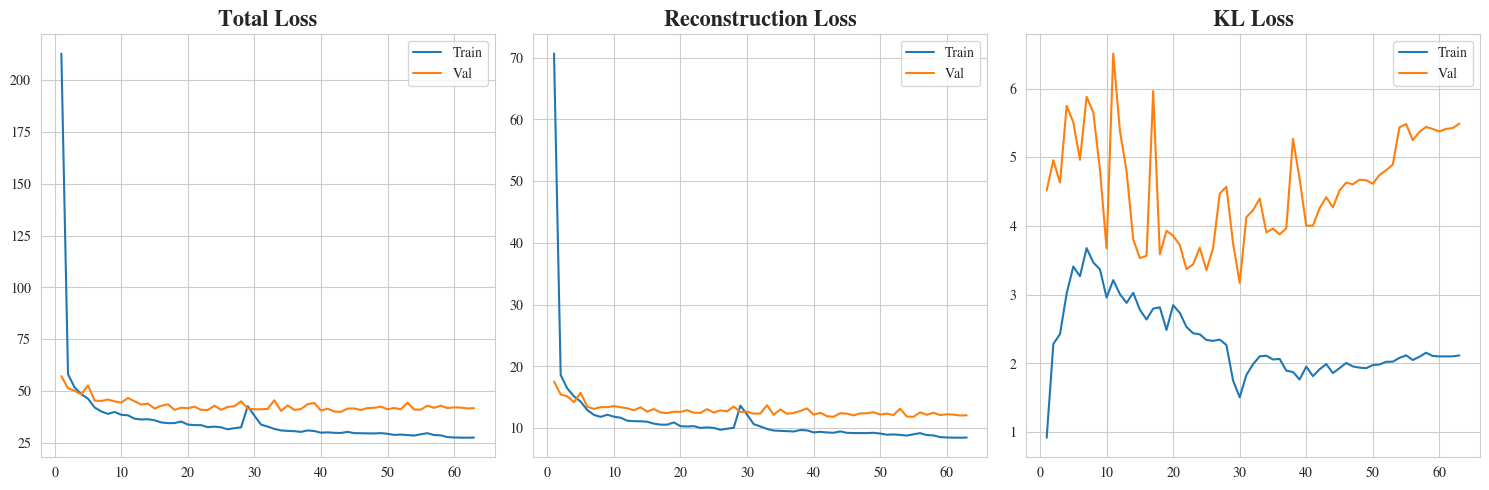

In [31]:
def plot_history(history):
    loss_dict = history.history

    loss_train = loss_dict["loss"]
    loss_val = loss_dict["val_loss"]

    rec_loss = loss_dict["reconstruction_loss"]
    rec_loss_val = loss_dict["val_reconstruction_loss"]

    kl_loss = loss_dict["kl_loss"]
    kl_loss_val = loss_dict["val_kl_loss"]

    x = [i+1 for i in range(0, len(loss_train))]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    axes[0].set_title("Total Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=loss_train, label="Train", ax=axes[0])
    sns.lineplot(x=x, y=loss_val, label="Val", ax=axes[0])

    axes[1].set_title("Reconstruction Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=rec_loss, label="Train", ax=axes[1])
    sns.lineplot(x=x, y=rec_loss_val, label="Val", ax=axes[1])

    axes[2].set_title("KL Loss", size=16, fontweight="bold")
    sns.lineplot(x=x, y=kl_loss, label="Train", ax=axes[2])
    sns.lineplot(x=x, y=kl_loss_val, label="Val", ax=axes[2])
    fig.tight_layout()

plot_history(history)

## Save Model

In [32]:
#vae.save("../models/e64_b2_43k_params")

# Load Model
#vae = tf.keras.models.load_model("../models/e32-b1_final_dir")

# Reconstruction Plotting

In [33]:
train_sample = np.expand_dims(tensor[0], axis=0)
print(train_sample.shape)

(1, 250, 7)


In [34]:
train_sample_reconstructed = vae.predict(train_sample)

1/1 [==============================] - 1s 1s/step


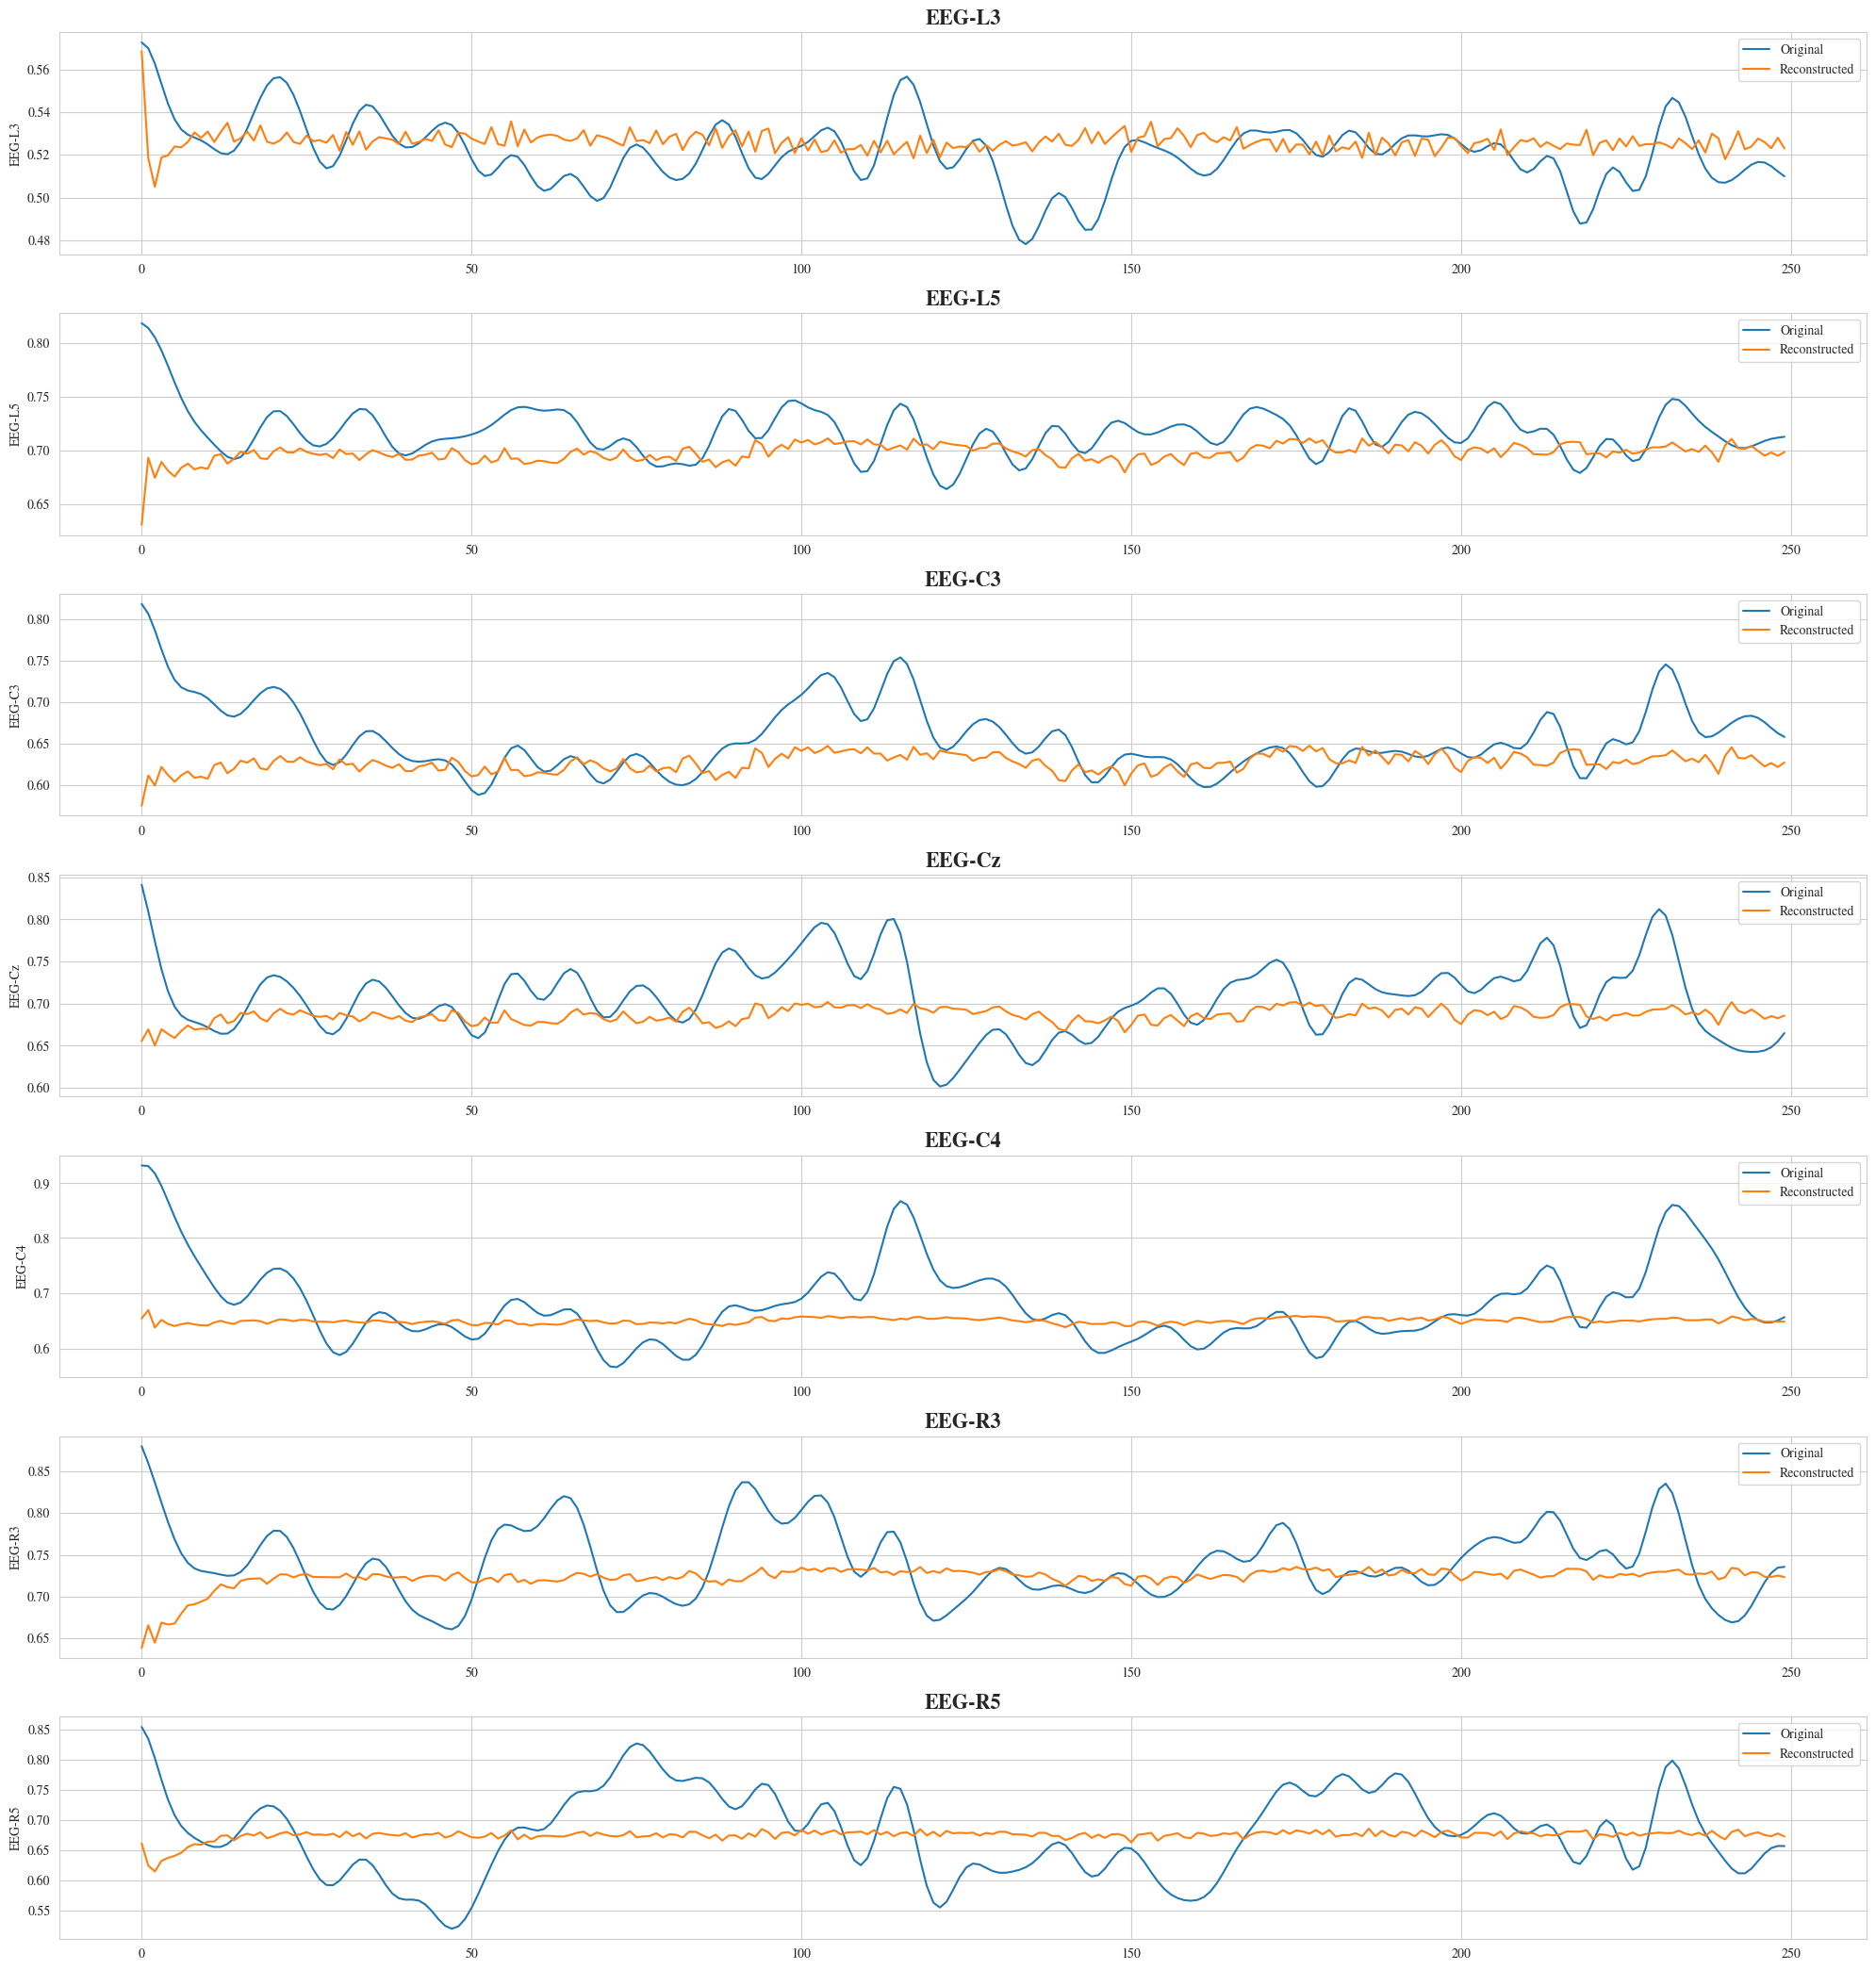

In [89]:
# Compare original and reconstruction
def compare_original_and_reconstruction(sample: np.array, sample_reconstructed: np.array) -> None:
    df_sample = pd.DataFrame(sample, columns=FEATURE_NAMES)
    df_reconstructed = pd.DataFrame(sample_reconstructed, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(FEATURE_NAMES), ncols=1, figsize=(20, len(FEATURE_NAMES)*3))
    for col, ax in zip(FEATURE_NAMES, axes.flatten()):
        sns.lineplot(data=df_sample, x=df_sample.index, y=col, ax=ax, label="Original")
        sns.lineplot(data=df_reconstructed, x=df_reconstructed.index, y=col, ax=ax, label="Reconstructed")
        #ax.fill_between(df_reconstructed.index, df_sample[col], df_reconstructed[col], color='lightcoral', label="Error")
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()


compare_original_and_reconstruction(train_sample[0], train_sample_reconstructed[0])

# Generate new Samples by Sampling from latent space

In [91]:
# Generate synthetic data function using the decoder part of the VAE
def generate_time_series_conditioned_on_x(x: np.array, num_samples: int, latent_dims: int):
    # Get mean and log_variance from encoding x
    z_mean, z_log_var, _ = vae.encoder.predict(x)
    # Sample from the latent space
    latent_samples = np.random.normal(size=(num_samples, latent_dims), loc=z_mean, scale=np.exp(z_log_var))
    print(f"Latent Samples: {latent_samples}")
    print("z_mean: ", z_mean)
    print("z_log_Var: ", z_log_var)
    # Generate synthetic data using the decoder model
    synthetic_data = vae.decoder(latent_samples).numpy()
    return synthetic_data

def sample_from_prior_z(num_samples: int, latent_dims: int):
    z = np.random.normal(size=(num_samples, latent_dims))
    return z

def get_samples_given_z(z):
    samples = vae.decoder(z).numpy()
    return samples

# Generate synthetic time series data
num_samples = 1
#synthetic_time_series = generate_time_series_conditioned_on_x(train_sample, num_samples, latent_dims=LATENT_DIM)
synthetic_time_series = get_samples_given_z(sample_from_prior_z(num_samples, LATENT_DIM))
print(synthetic_time_series.shape)

(1, 250, 7)


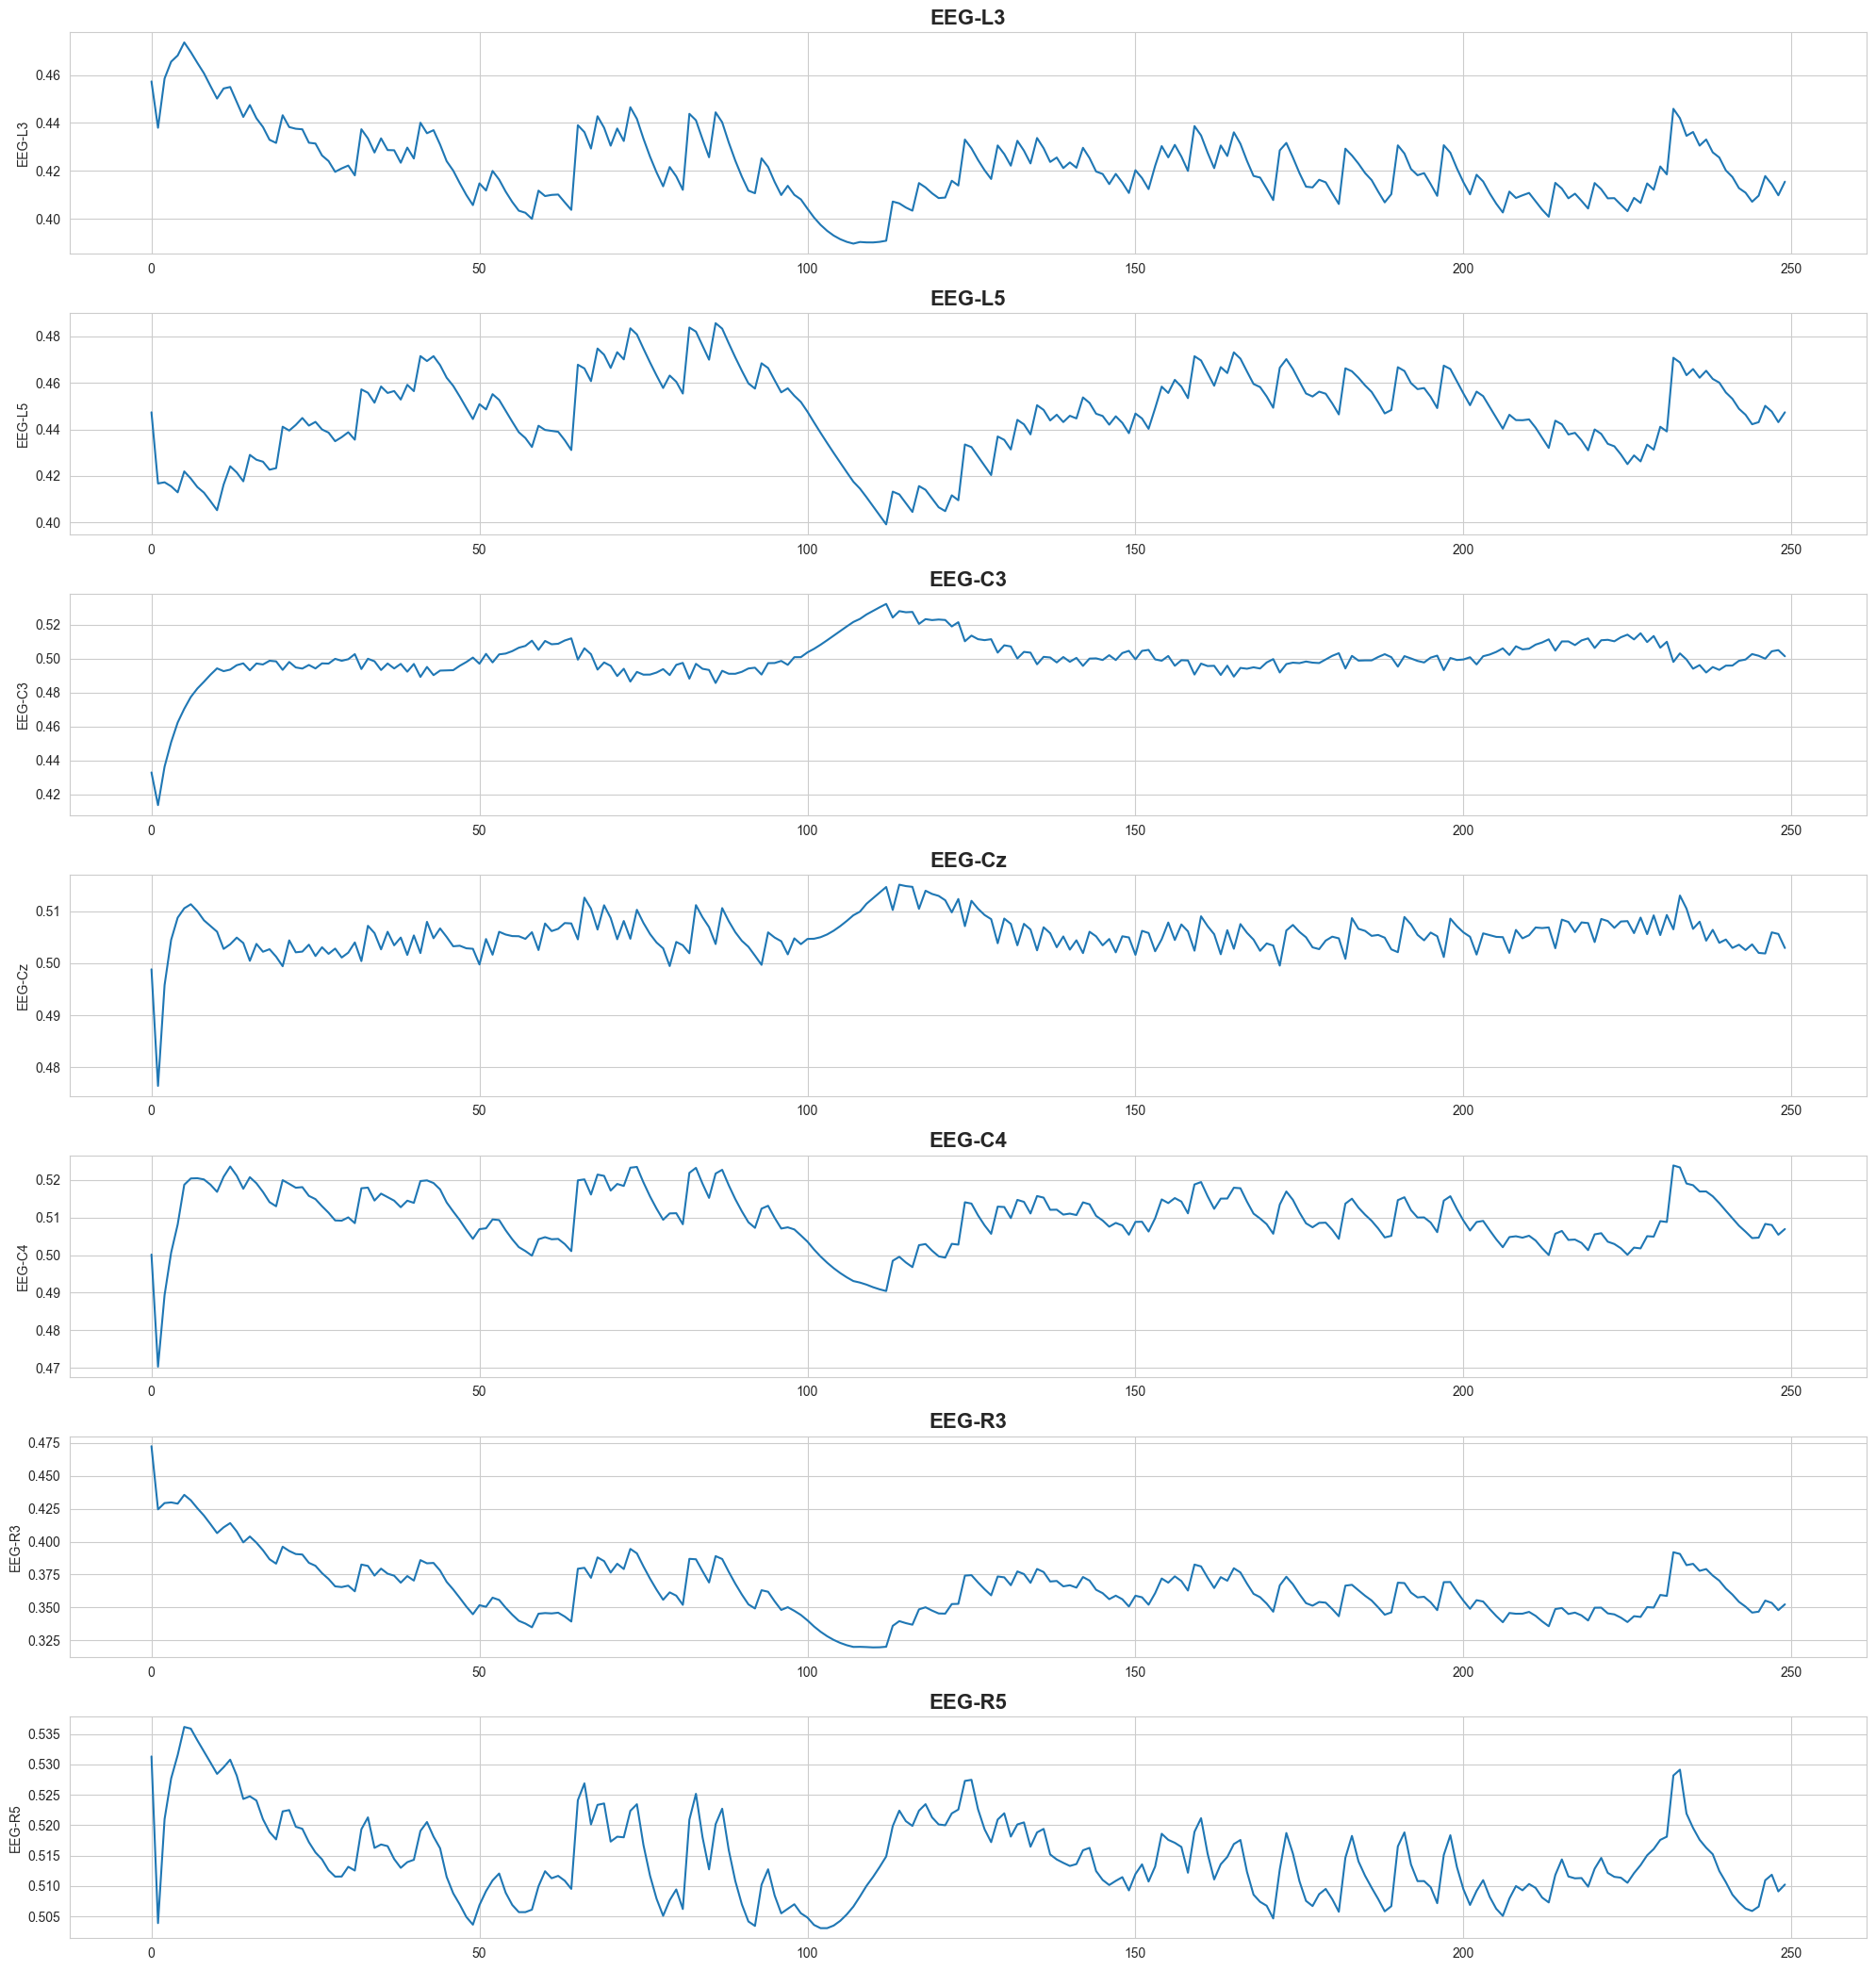

In [140]:
def plot_all_time_series(X: np.array) -> None:
    """ Plots all Time Series (all float64 columns) in the provided DataFrame

    :param x: np.array -- Input data of shape (N_SEQ, N_FEATS)
    :param time_col: str -- Name of the time column
    :return: None
    """
    df = pd.DataFrame(X, columns=FEATURE_NAMES)

    fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(20, len(df.columns)*3))
    for col, ax in zip(df.columns, axes.flatten()):
        sns.lineplot(data=df, x=df.index, y=col, ax=ax)
        ax.set_title(col, fontweight="bold", size=16)
    fig.tight_layout()

plot_all_time_series(synthetic_time_series[0])

# Visualize latent space / posterior
$$ q_\Phi(z|x) \approx p\theta(z|x) $$

In [51]:
def encode_batch(x: np.array):
    z_mean, z_log_var, z = vae.encoder(x)
    return z_mean, z_log_var, z

z_mean, z_log_var, z = encode_batch(tensor)

In [52]:
from sklearn.manifold import TSNE

In [53]:
tsne = TSNE(perplexity=10)
z_dim_reduced = tsne.fit_transform(z_mean)

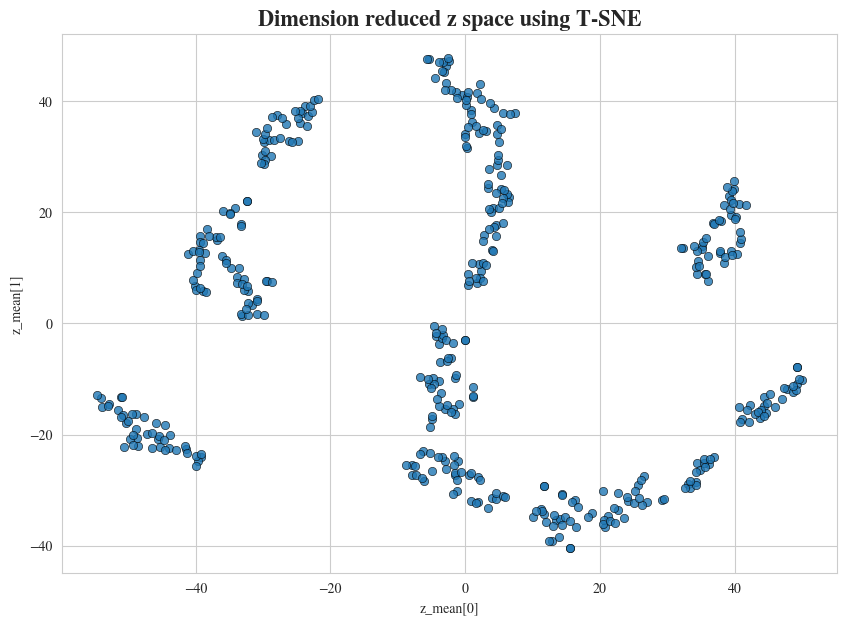

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using T-SNE", fontweight="bold", size=16)
sns.scatterplot(x=z_dim_reduced[:,0], y=z_dim_reduced[:,1], ax=ax, edgecolor="black", alpha=.8)
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

# Visualize using PCA

In [102]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

N_PCS: int = 2
N_CLUSTERS: int = 3
    
pca = PCA(n_components=N_PCS, random_state=42)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)

In [103]:
z_dim_reduced_pca = pca.fit_transform(z_mean)
labels = kmeans.fit(z_mean).labels_

In [104]:
print(f"Total Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")
pca.explained_variance_ratio_

Total Explained Variance: 1.00


array([0.98667097, 0.00960433])

In [105]:
centroids = pca.transform(kmeans.cluster_centers_)
centroids

array([[ 2.09634426,  0.16674128],
       [-1.16071677,  0.05622081],
       [ 0.23456764, -0.05765311]])

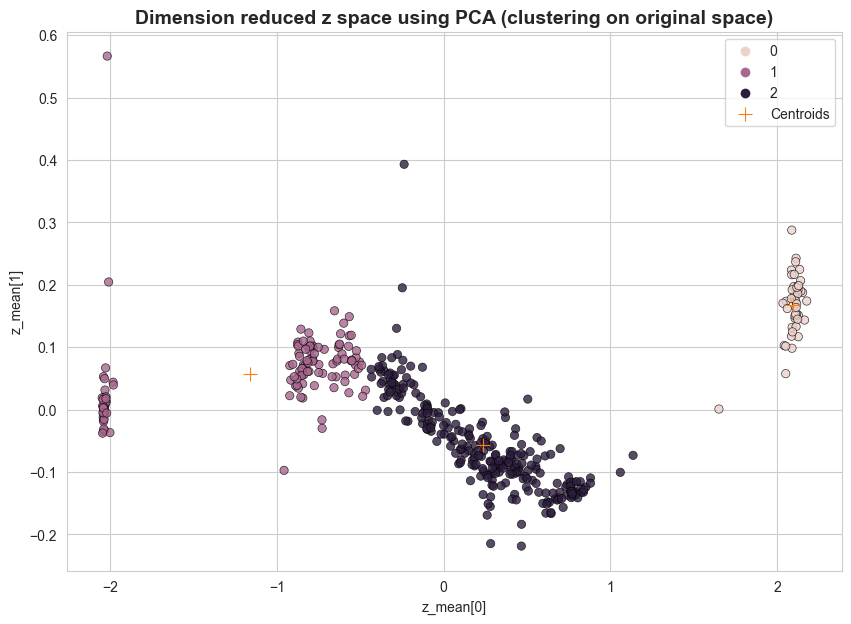

In [121]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title("Dimension reduced z space using PCA (clustering on original space)", fontweight="bold", size=14)
sns.scatterplot(x=z_dim_reduced_pca[:,0], y=z_dim_reduced_pca[:,1], ax=ax, edgecolor="black", alpha=.8, hue=labels)
sns.scatterplot(x=centroids[:,0], y=centroids[:, 1], marker="+", label="Centroids", s=100, edgecolor="black")
ax.set_xlabel("z_mean[0]")
ax.set_ylabel("z_mean[1]")
fig.show()

In [86]:
# Pick a Sample and recounstruct
sample_z_mean = np.array([[0, 0]])
sample_z_mean = pca.inverse_transform(sample_z_mean)

In [87]:
sample_z_mean_reconstructed = vae.decoder(sample_z_mean)

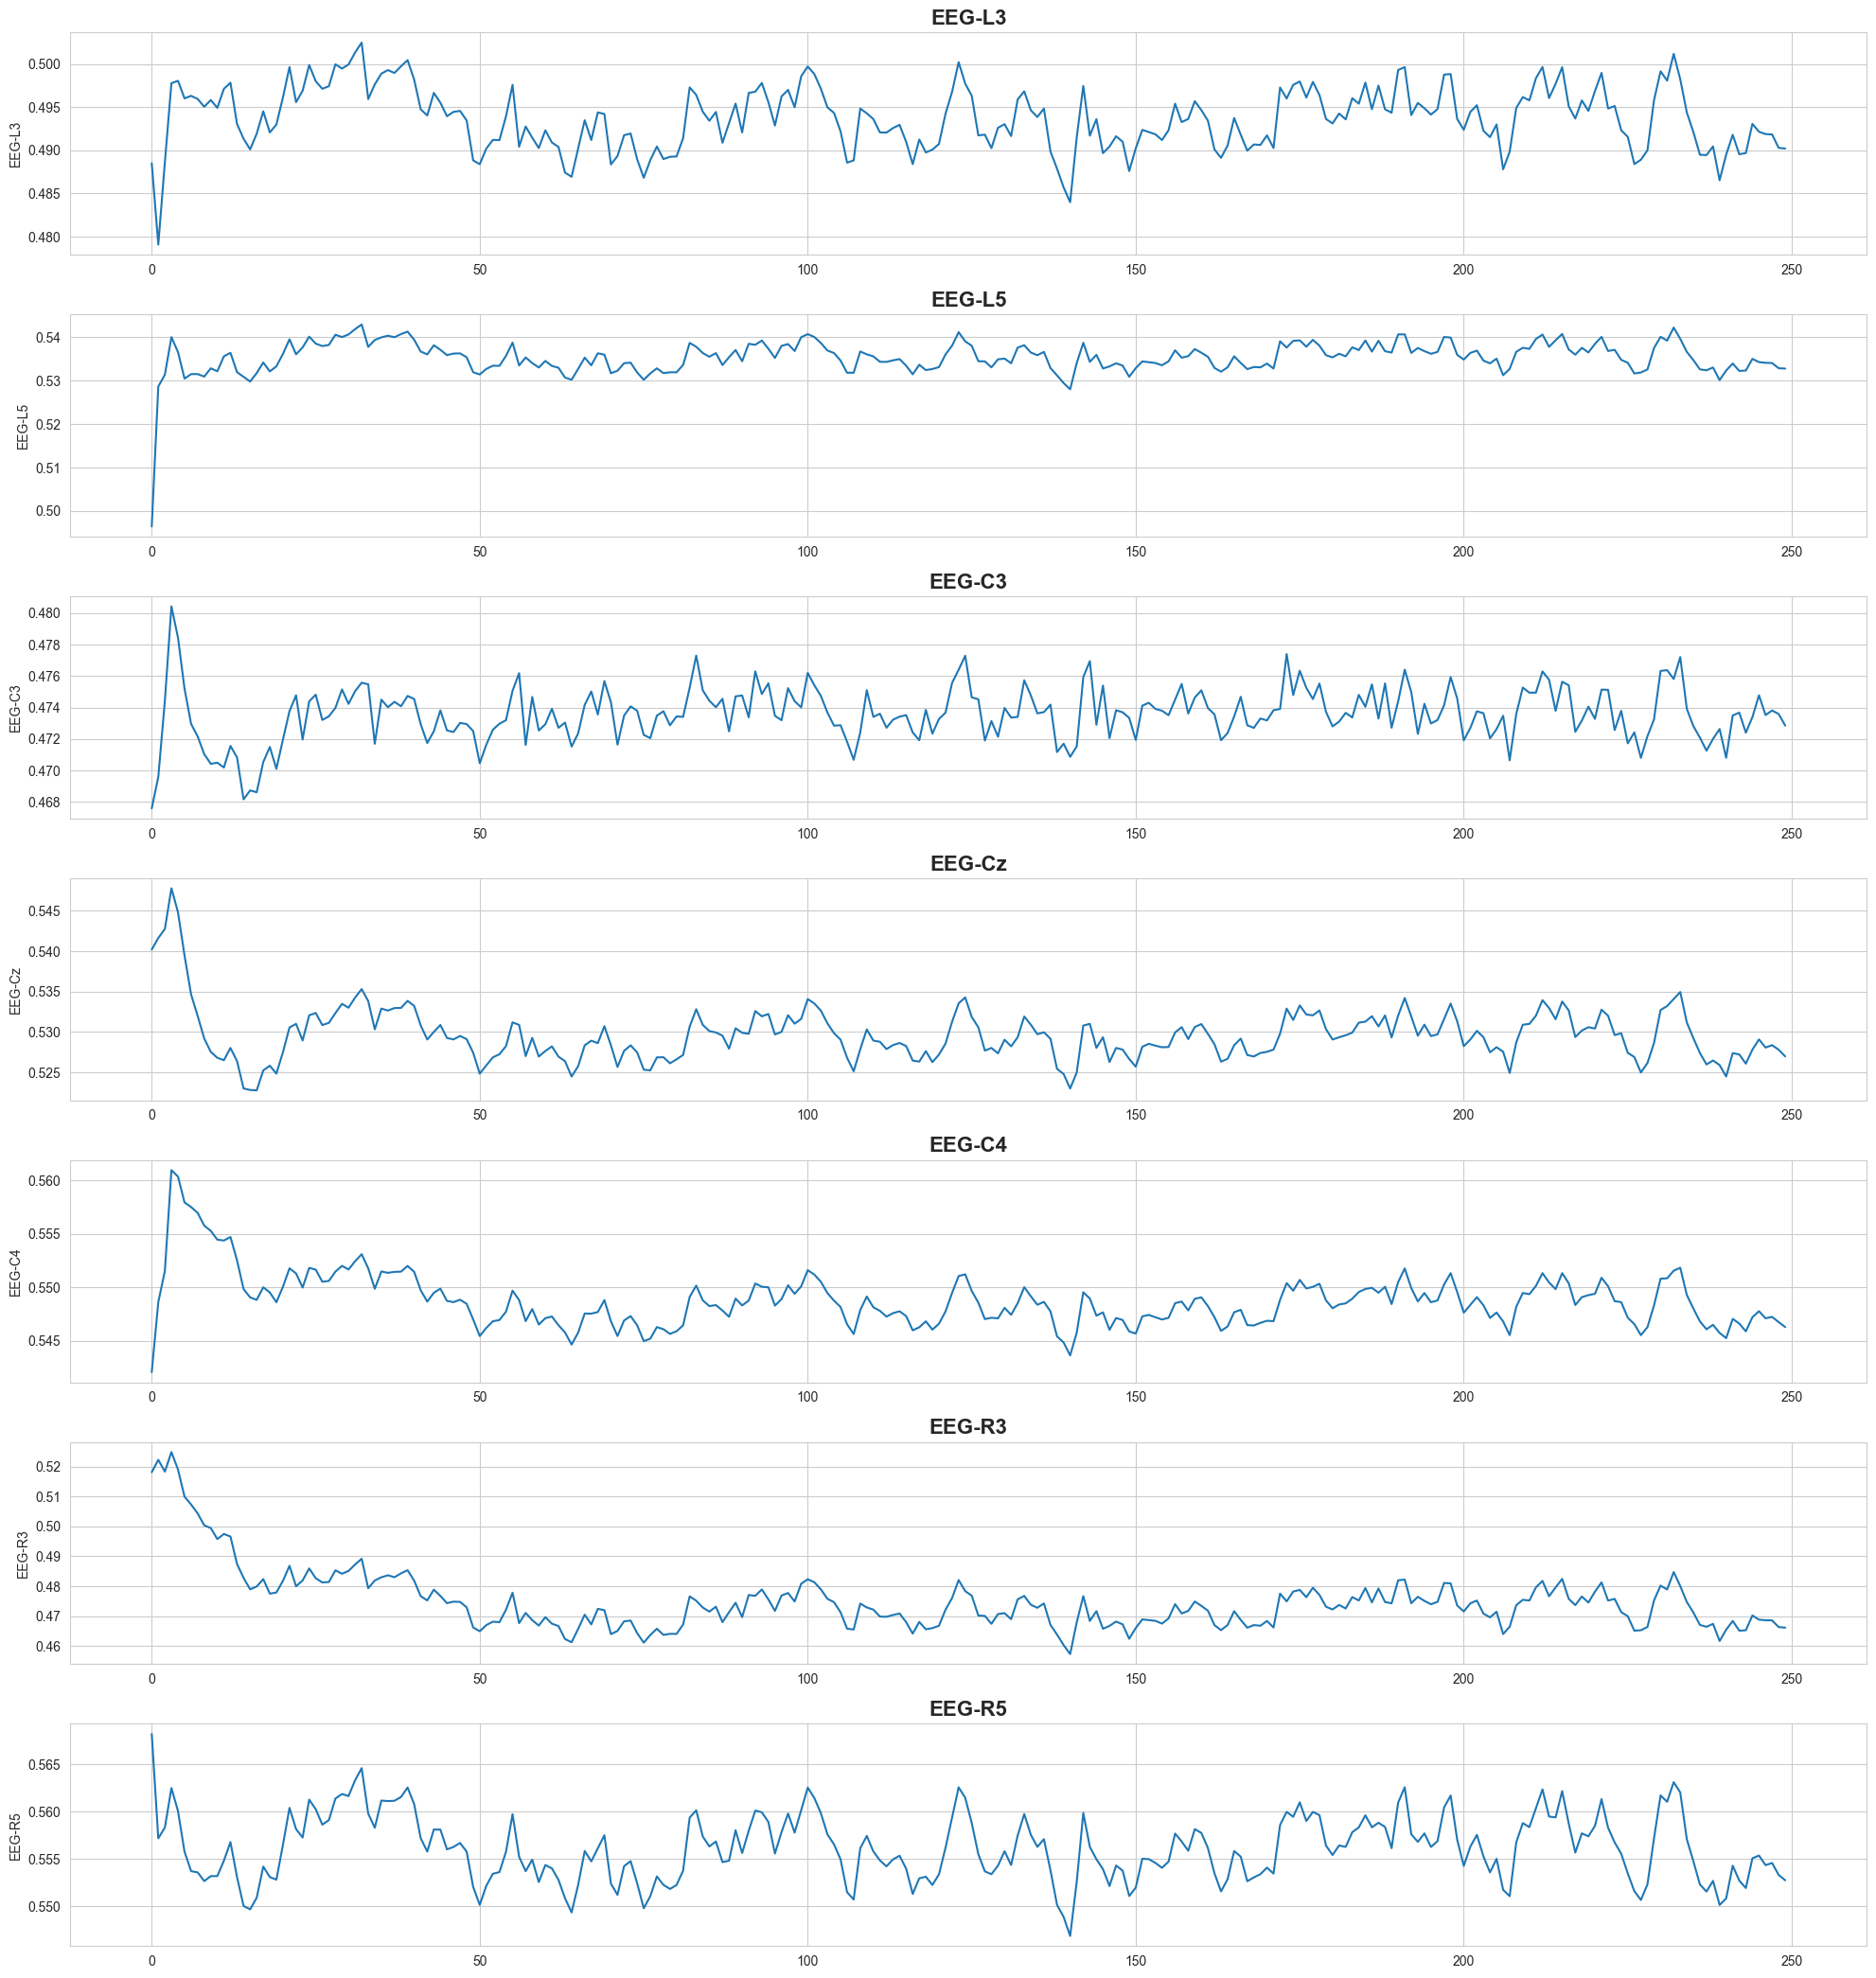

In [142]:
plot_all_time_series(sample_z_mean_reconstructed[0])

# Visualize Clusters

In [122]:
centroid_reconstructed = pca.inverse_transform(centroids)

In [124]:
samples_from_centroids = vae.decoder(centroid_reconstructed)

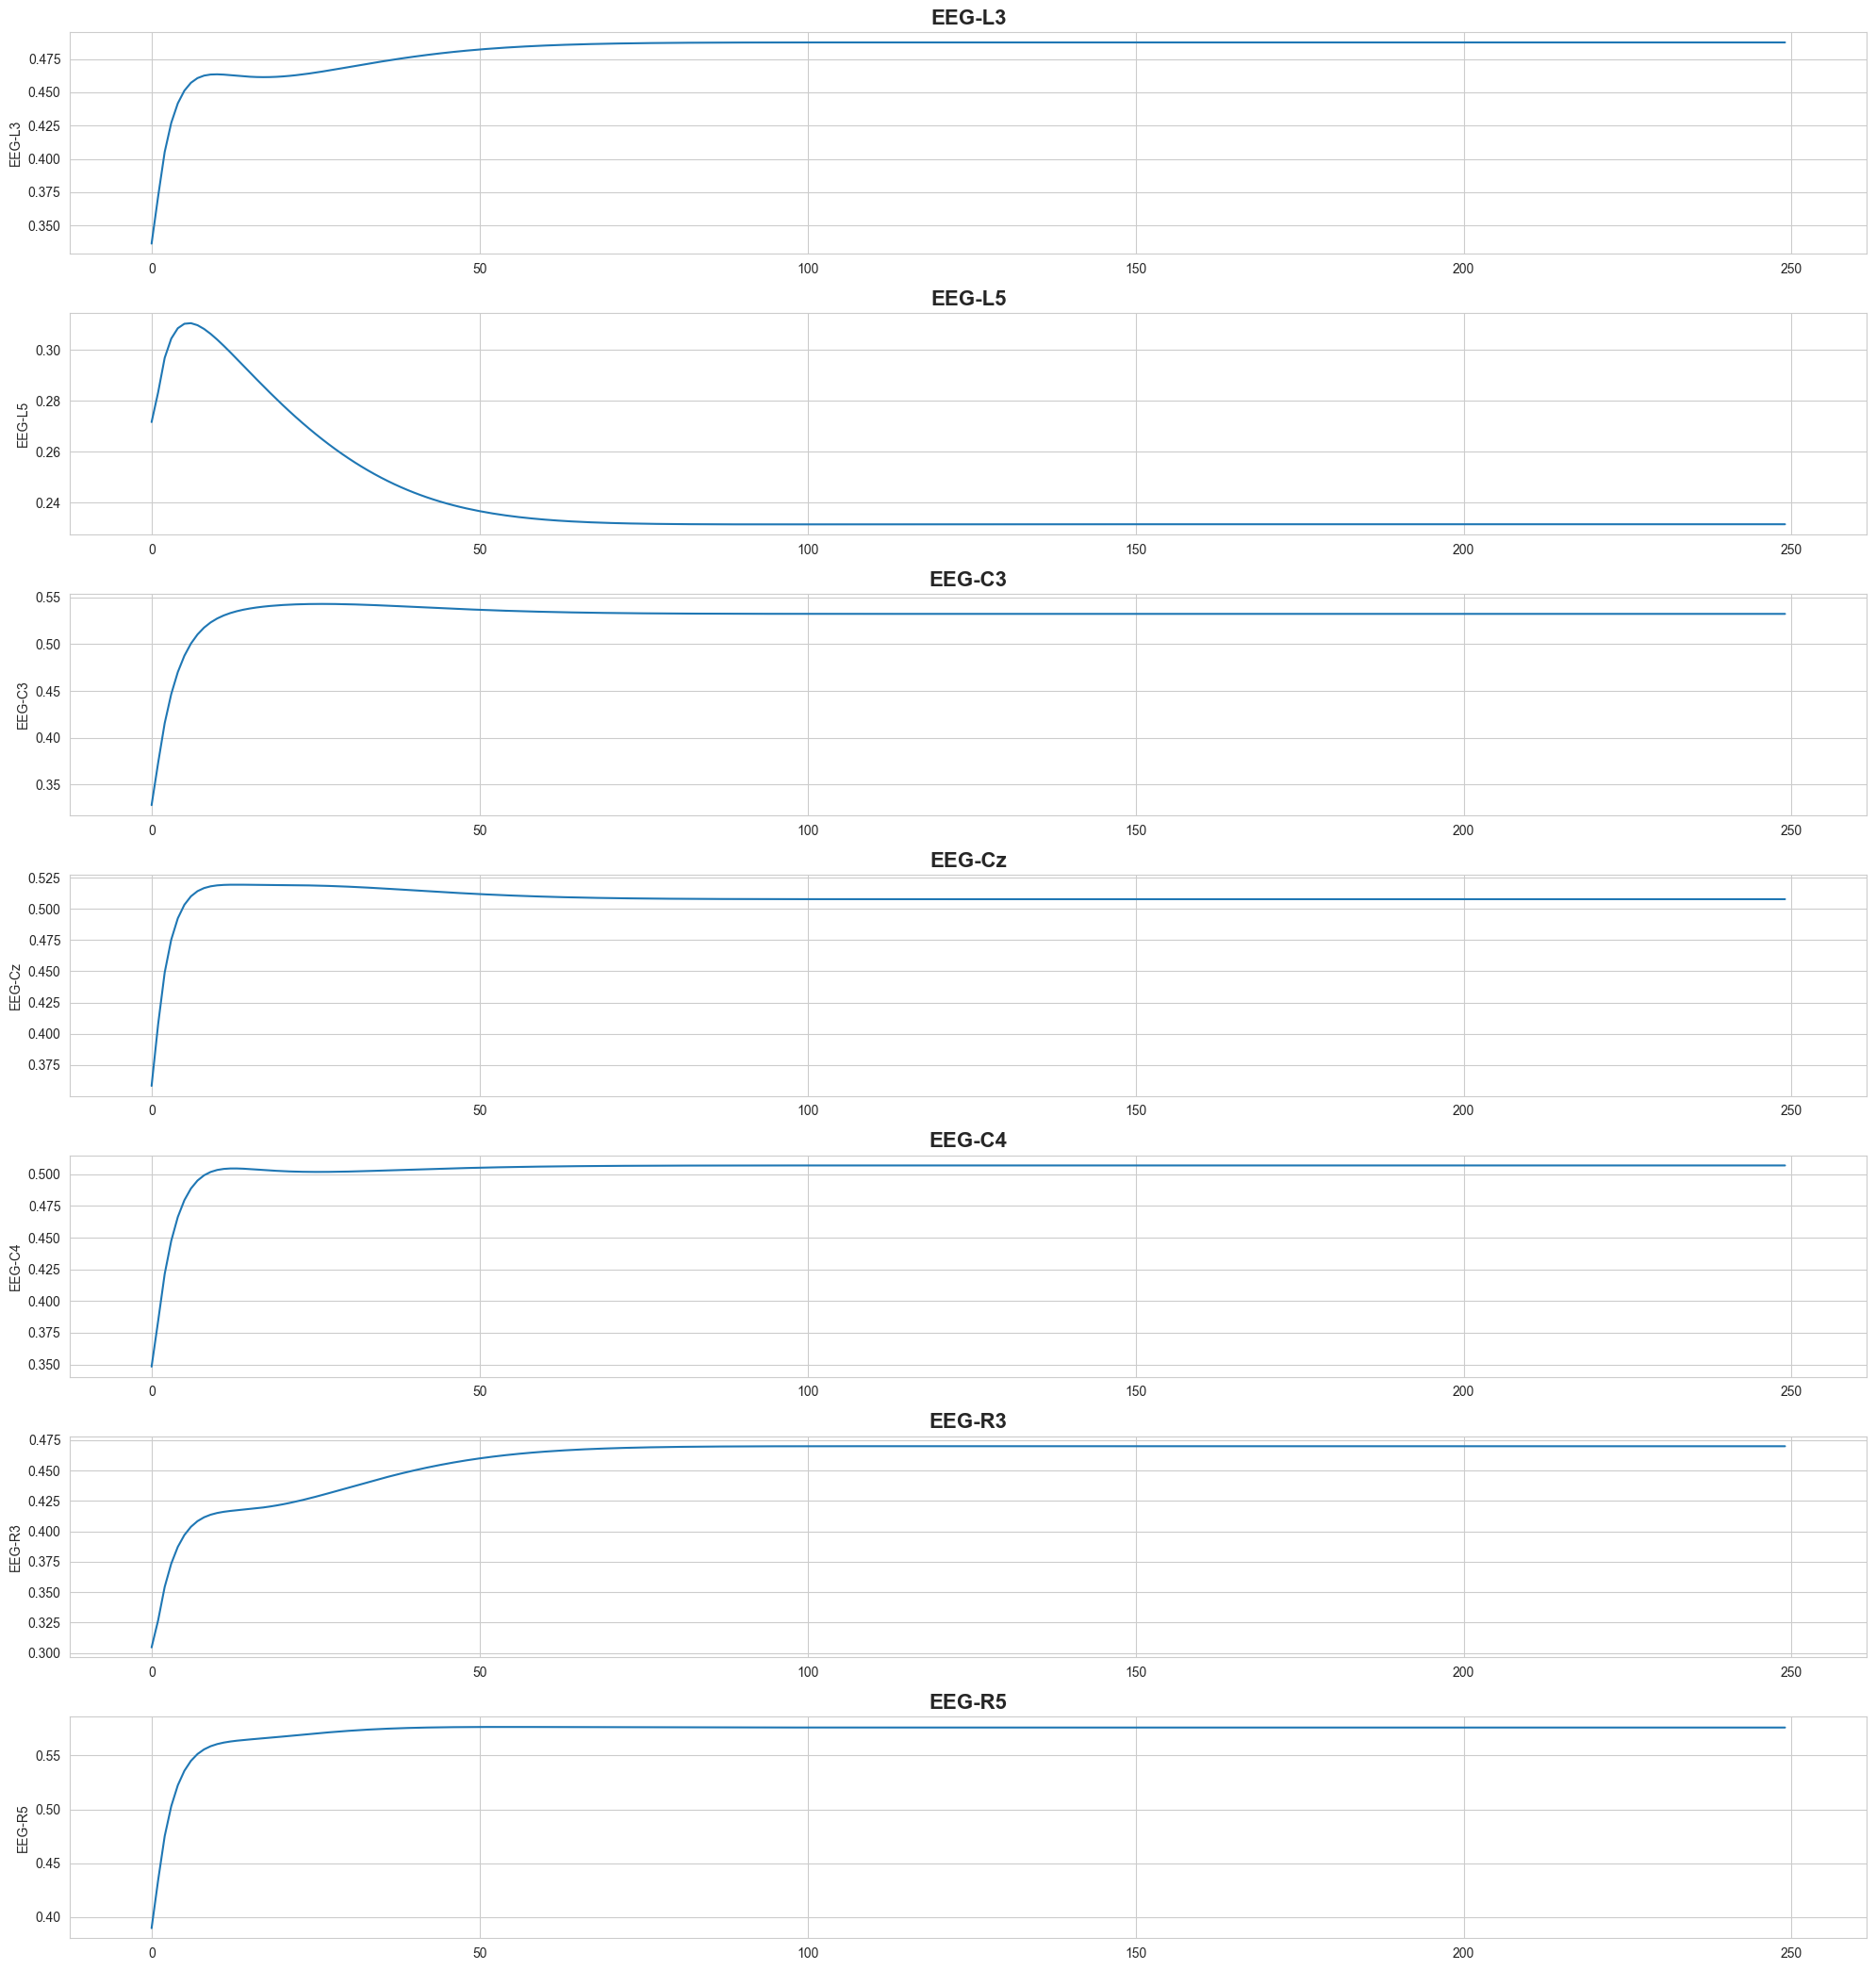

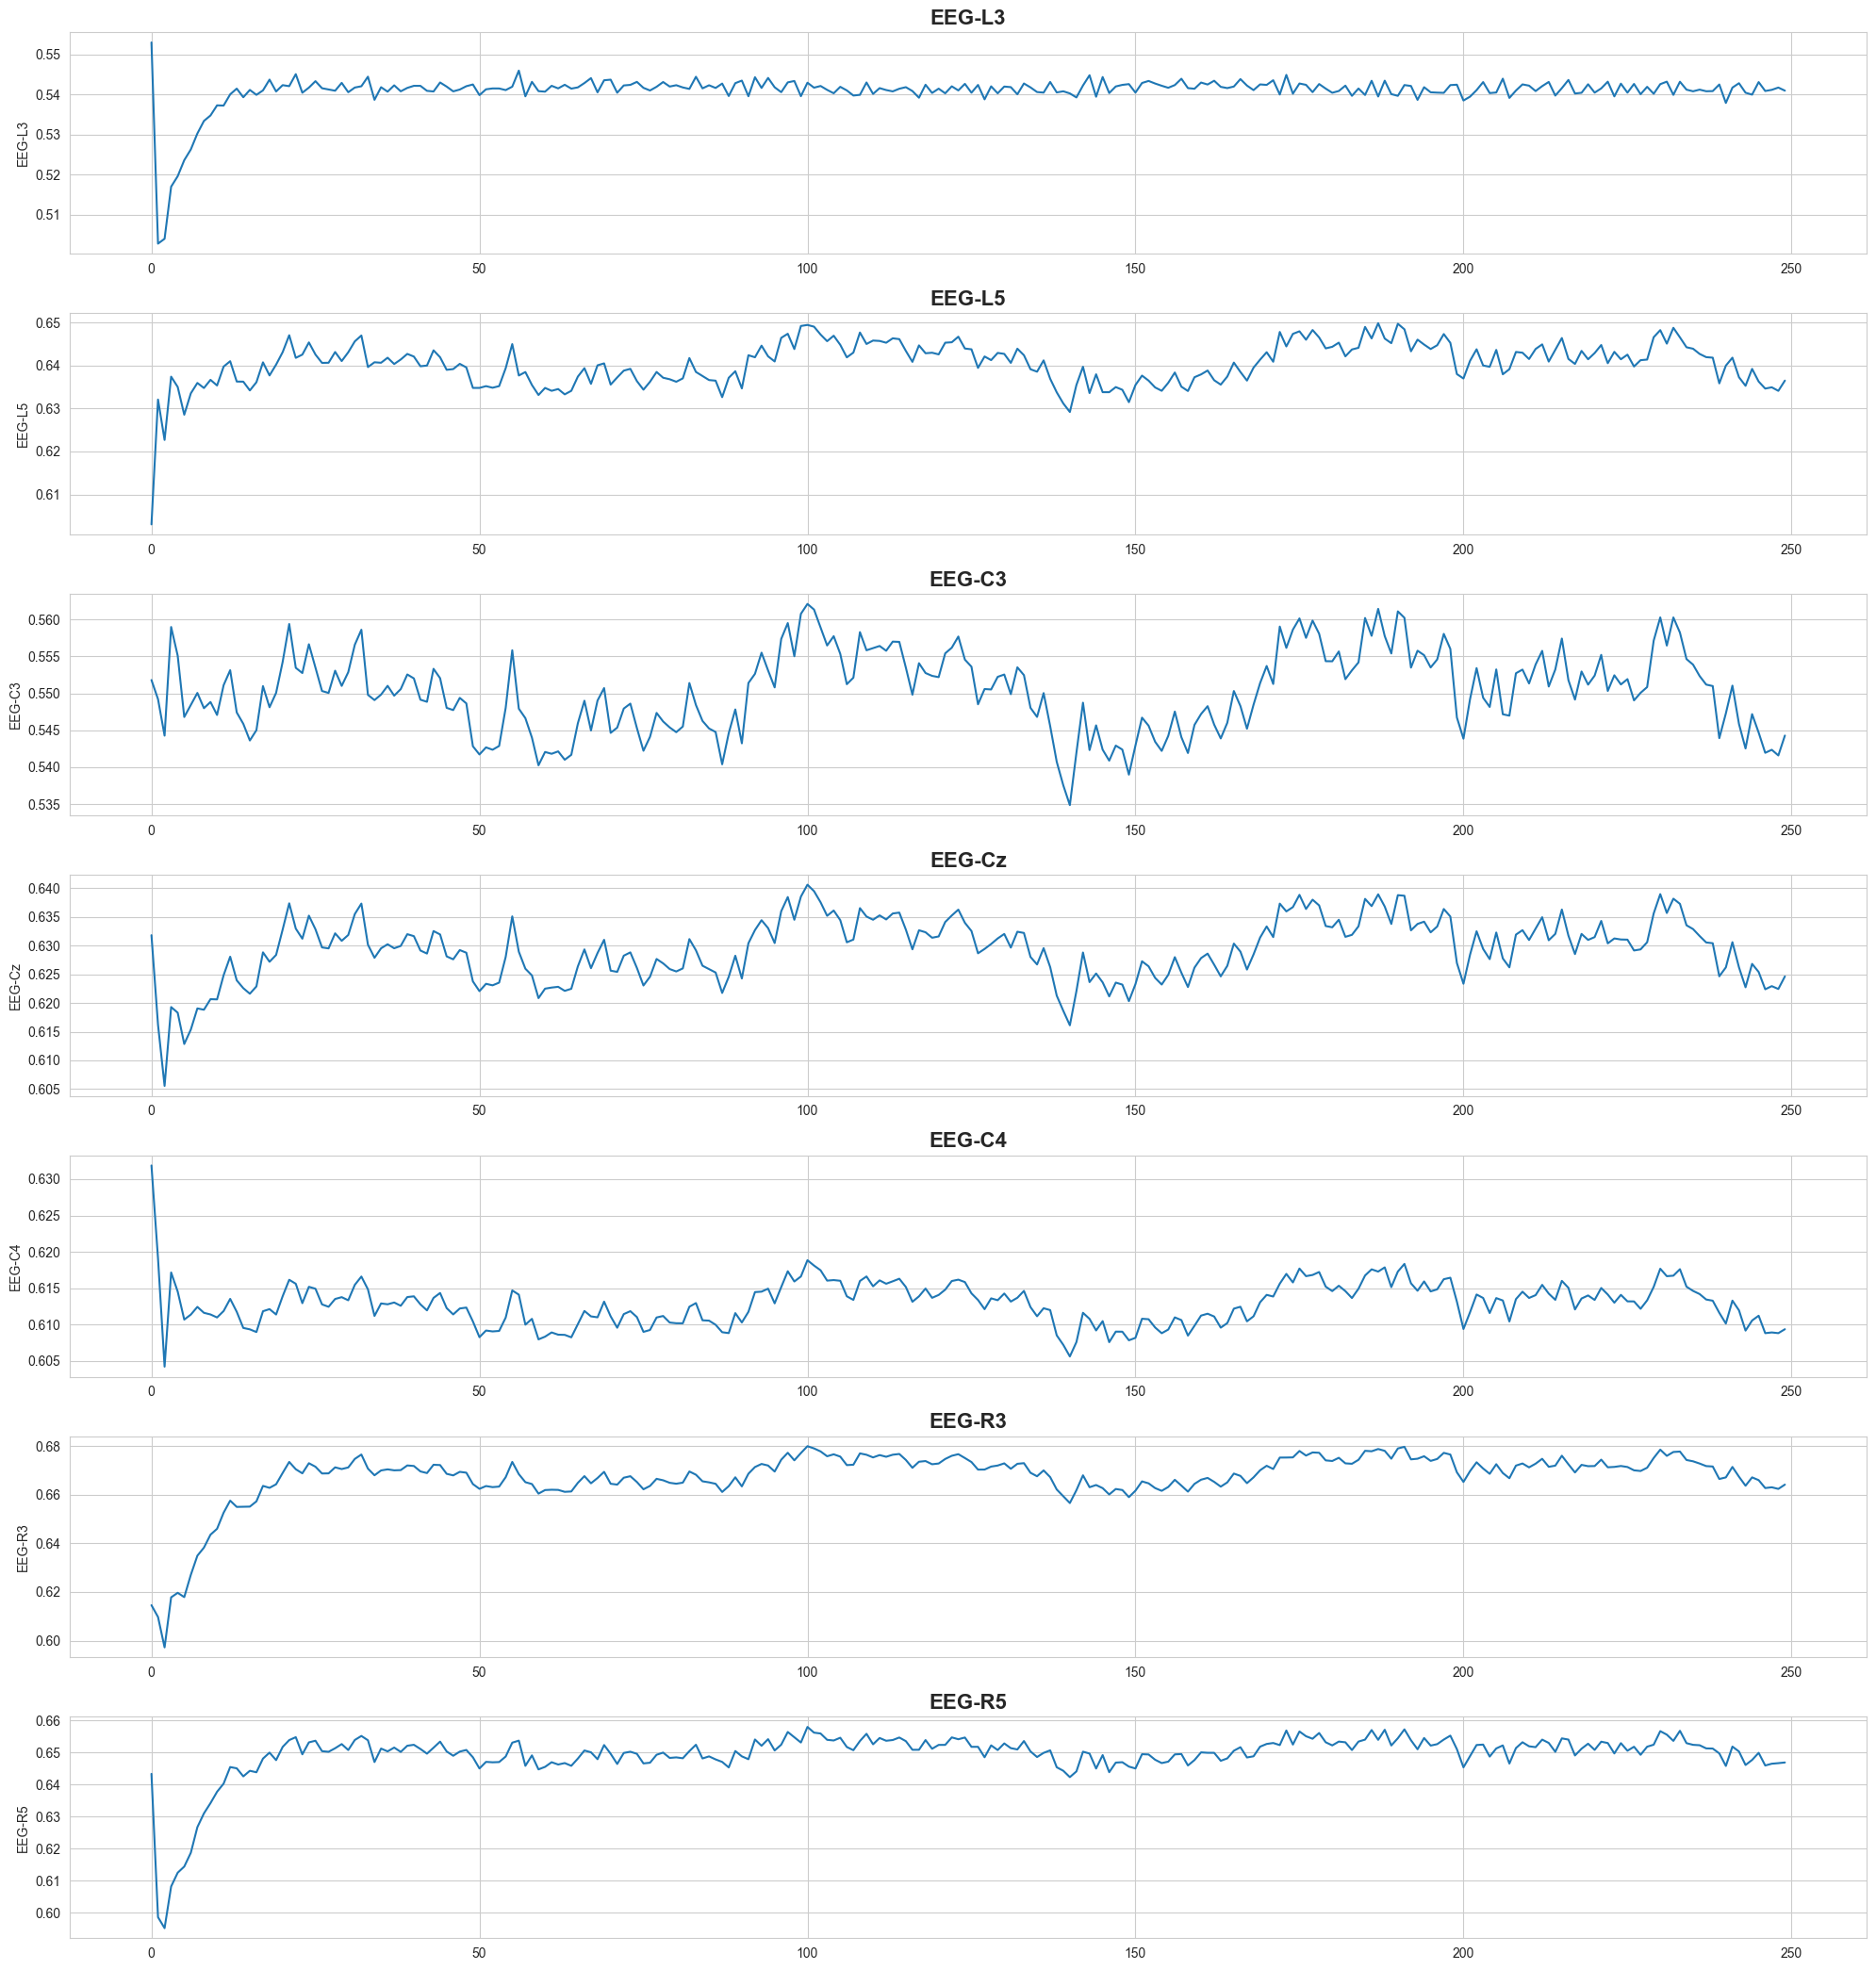

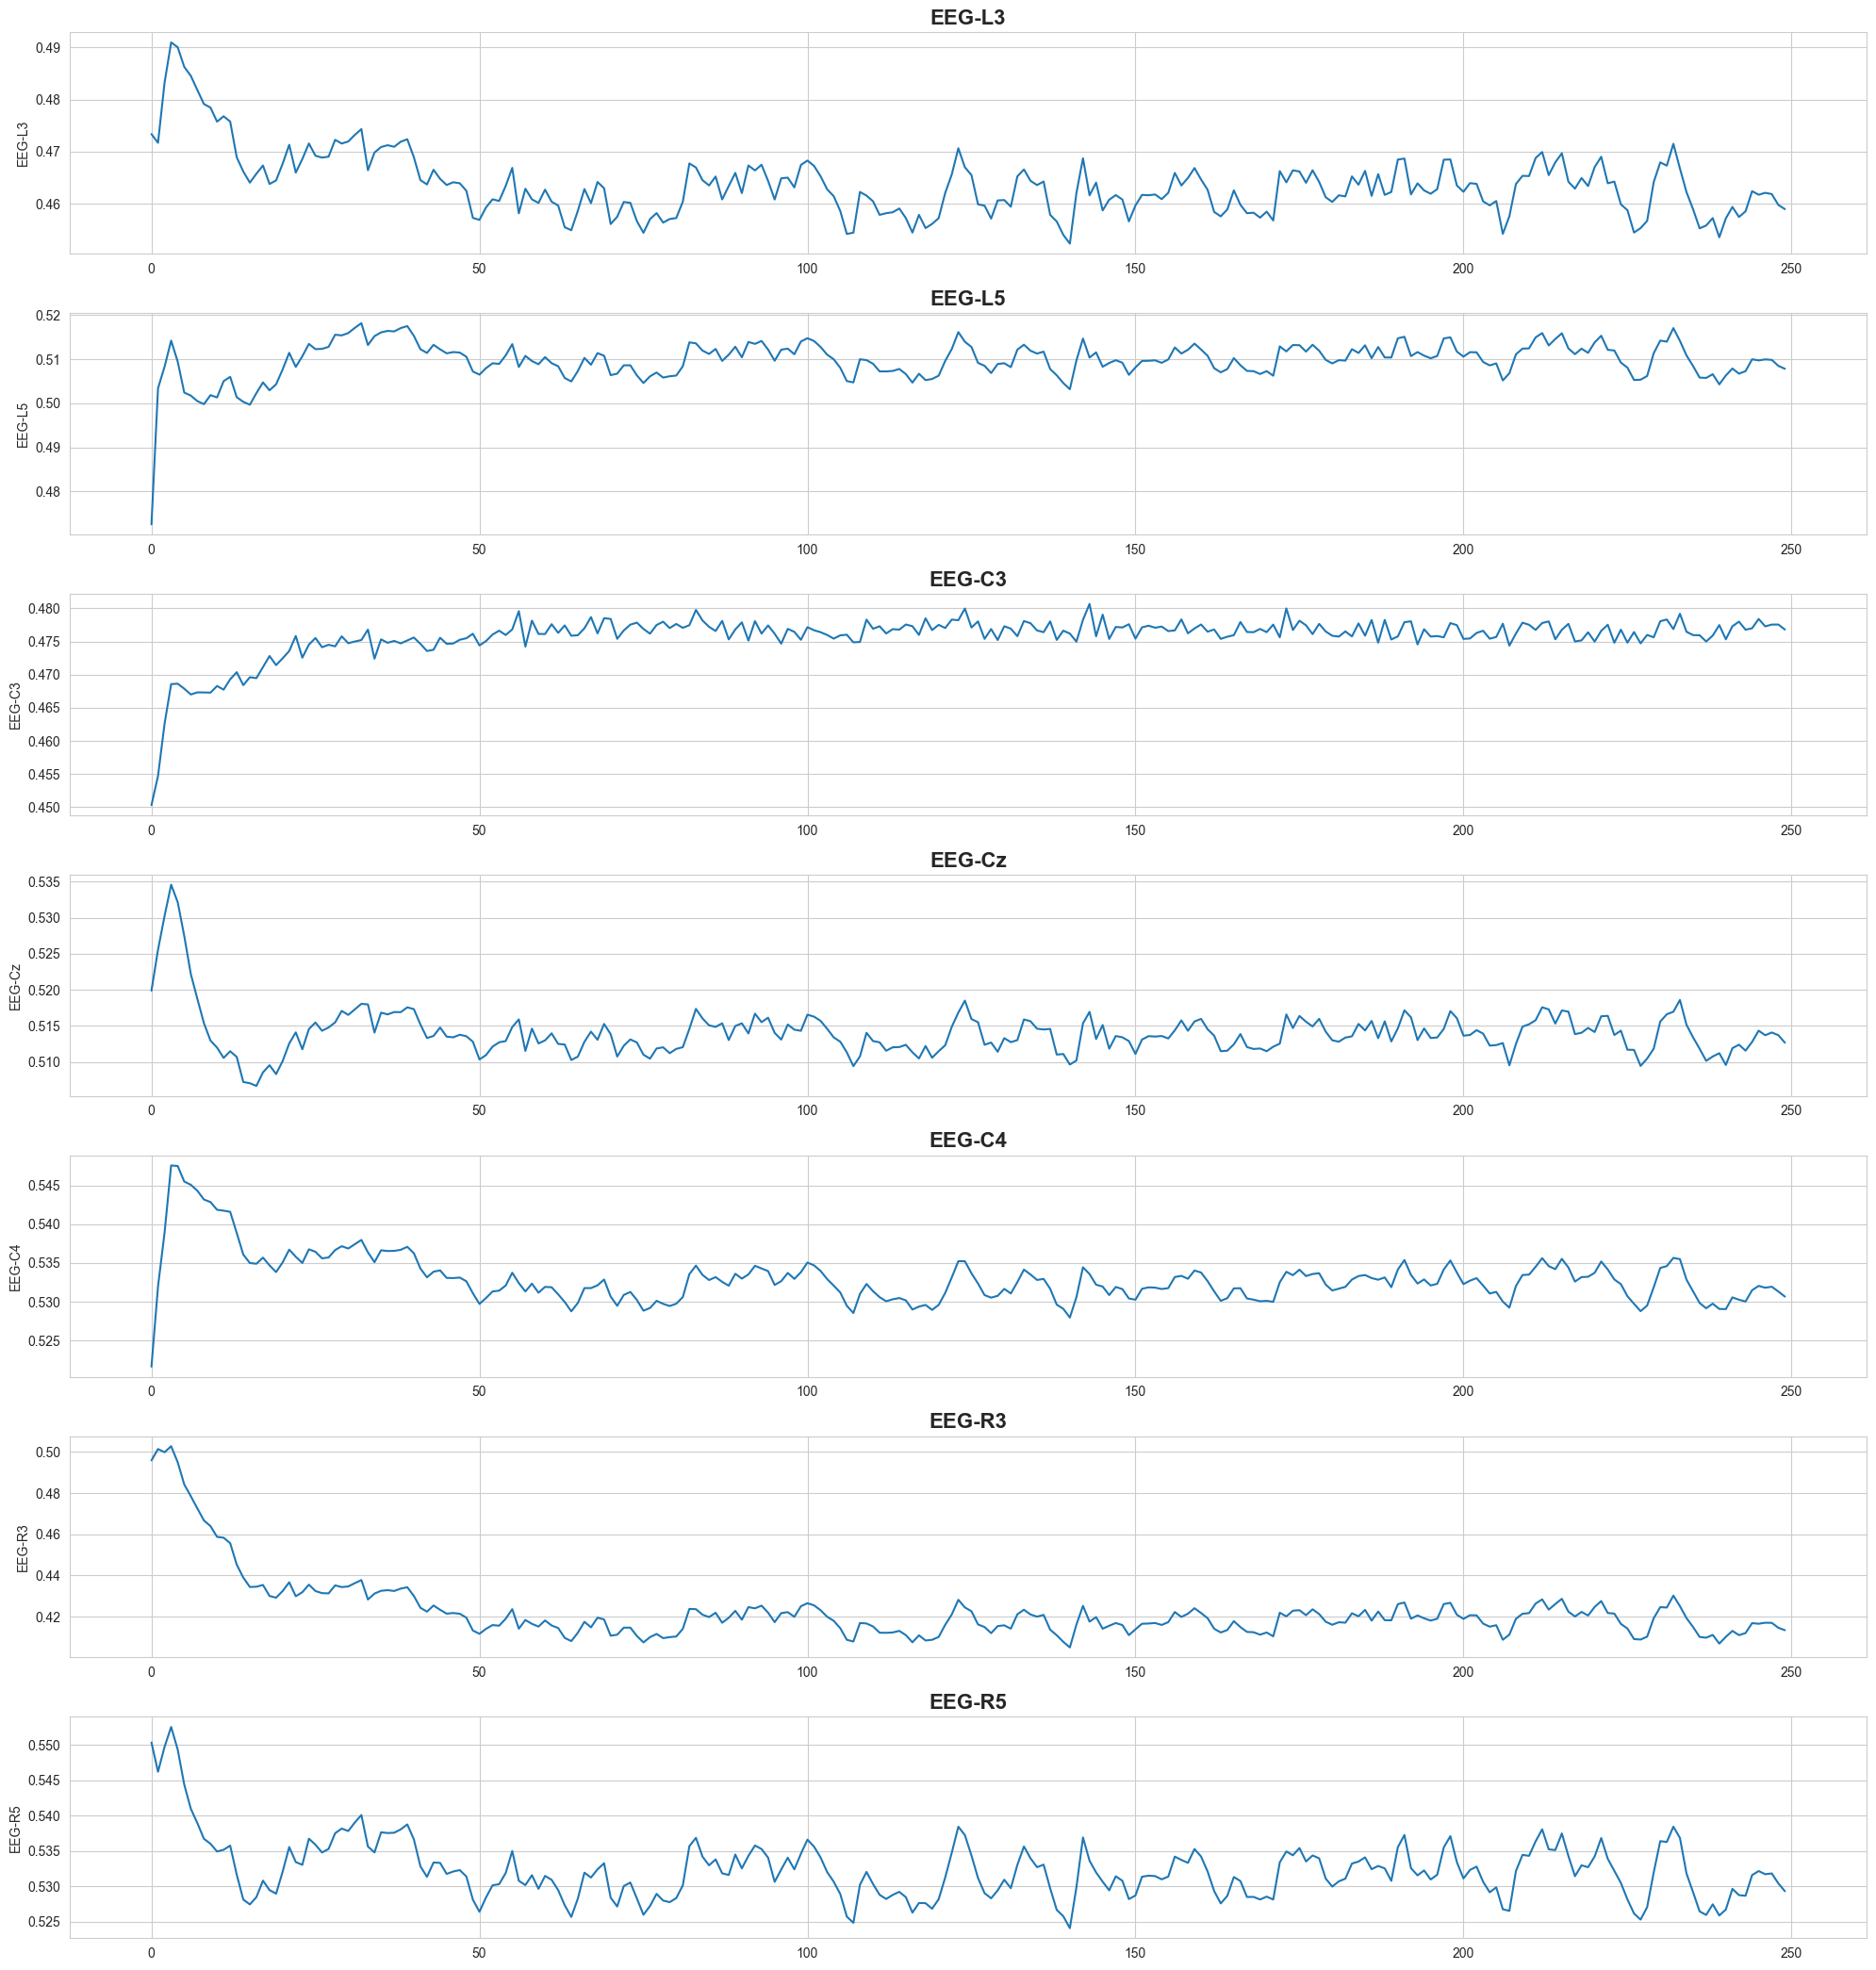

In [143]:
for i in range(samples_from_centroids.shape[0]):
    plot_all_time_series(samples_from_centroids[i])